# Can a Trained Classification Model Be Improved Without Additional Variables?
In this tutorial we show how to use the `kxy` package to quantify the extent to which a trained classification model can be improved without resorting to new datasets.

Specifically, we proceed backward. First, following [this classifiers benchmark from scikit-learn](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py), we train 10 different classifiers on 3 different synthetic dataset and compare their out-of-sample performances. Then we compare the results to our **improvability analysis**.

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

# Required imports
import pandas as pd
import seaborn as sns
import kxy

## Model Benchmarking

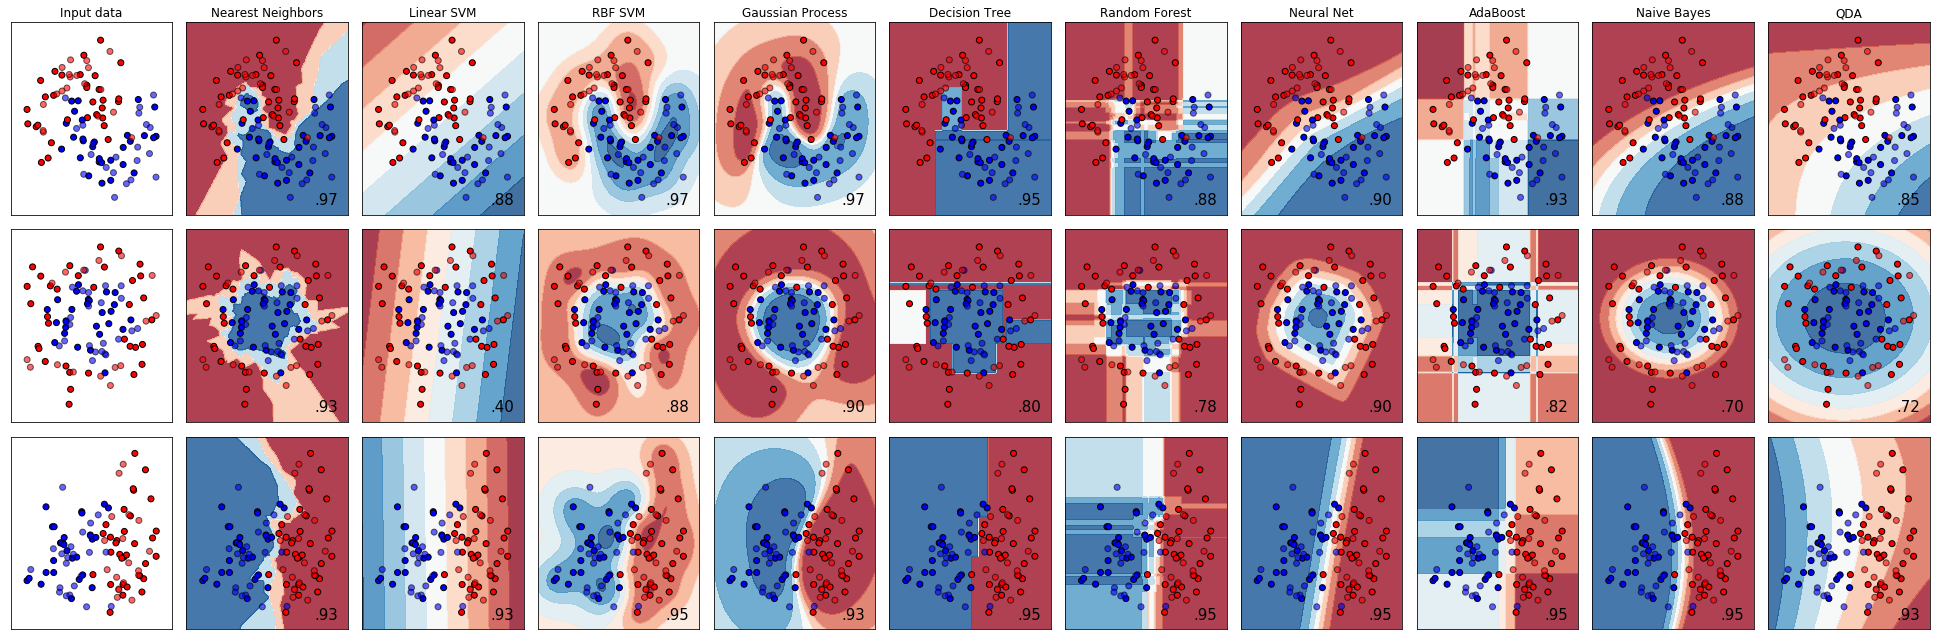

In [2]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for scikit-learn documentation by Jaques Grobler
# Modified for the purpose of this tutorial by KXY Technologies, Inc.
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
dfs = []
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1
    
    df = pd.DataFrame({'x_0': X_test[:, 0], 'x_1': X_test[:, 1], 'y': y_test})
    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        df[name + ' Prediction'] = clf.predict(X_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1
        
    dfs += [df.copy()]

plt.tight_layout()
plt.show()

## Improvability Analysis

### Lost Accuracy

In [3]:
all_lost_accuracy = pd.DataFrame({
    name: [dfs[i].kxy.model_improvability_analysis(\
        'y', name + ' Prediction', input_columns=['x_0', 'x_1'])\
        .data['Lost Accuracy'][0] for i in range(3)] for name in names})
all_lost_accuracy['Dataset ==>'] = [0, 1, 2]
all_lost_accuracy.set_index(['Dataset ==>'], inplace=True)
cm = sns.light_palette("red", as_cmap=True)
all_lost_accuracy.T\
.style.background_gradient(cmap=cm)\
.set_caption("Tab 1: Amount of classification accuracy each model "\
             "missed out on.")

Dataset ==>,0,1,2
Nearest Neighbors,0.021,0.071,0.073
Linear SVM,0.124,0.4,0.056
RBF SVM,0.021,0.084,0.038
Gaussian Process,0.021,0.069,0.073
Decision Tree,0.041,0.189,0.038
Random Forest,0.115,0.195,0.038
Neural Net,0.095,0.069,0.038
AdaBoost,0.073,0.113,0.038
Naive Bayes,0.124,0.184,0.038
QDA,0.15,0.17,0.056


### Interpretation
For each dataset, our estimation of how much accuracy it lost or, equivalently, the difference between the accuracy it achieved out-of-sample and our estimation of the maximum accuracy that could have been achieved using the same inputs, is indeed consistent with the performances of other models. In particular, we recover the fact that the best (resp. worst) performing model has the smallest (resp. biggest) lost accuracy. 

We get a similar picture using the lost $R^2$ instead of the lost accuracy.

### Lost $R^2$

In [4]:
all_lost_r_squared = pd.DataFrame({
    name: [dfs[i].kxy.model_improvability_analysis(\
        'y', name + ' Prediction', input_columns=['x_0', 'x_1'])\
        .data['Lost R^2'][0] for i in range(3)] for name in names})
all_lost_r_squared['Dataset ==>'] = [0, 1, 2]
all_lost_r_squared.set_index(['Dataset ==>'], inplace=True)
all_lost_r_squared.round(3).T\
.style.background_gradient(cmap=cm)\
.set_caption(r'Tab 2: Amount of $R^2$ each model missed out on.')

Dataset ==>,0,1,2
Nearest Neighbors,0.289,0.248,0.416
Linear SVM,0.512,0.813,0.38
RBF SVM,0.289,0.276,0.341
Gaussian Process,0.289,0.243,0.416
Decision Tree,0.334,0.5,0.341
Random Forest,0.494,0.512,0.341
Neural Net,0.451,0.243,0.341
AdaBoost,0.405,0.341,0.341
Naive Bayes,0.512,0.49,0.341
QDA,0.566,0.462,0.38
